In [ ]:
%load_ext autoreload
%autoreload 2
import stim
import numpy as np
import matplotlib.pyplot as plt
import sinter
from typing import List
import surface_general_defect
from surface_general_defect import LogicalQubit
from simple_grid import chiplet
import math

In [51]:
import math

def depol_from_delay(delay_s, T1=200e-6, T2=150e-6, p_base=1e-3):
    """
    Calculate effective depolarizing probabilities (p1, p2, pprep, pmeas)
    given just the idle delay in seconds.

    delay_s : float  → idle time in seconds
    T1, T2  : float  → relaxation and dephasing times (default: 200µs, 150µs)
    p_base  : float  → baseline per-gate depolarizing error (default: 1e-3)
    """
    # Equivalent idle-induced depolarization
    p_idle = (3 - math.exp(-delay_s / T1) - 2 * math.exp(-delay_s / T2)) / 2

    # Combine baseline + idle noise (assuming independence)
    p_eff = 1 - (1 - p_base) * (1 - p_idle)

    return {
        "p1": p_eff,
        "p2": p_eff,
        "pprep": p_eff,
        "pmeas": p_eff,
        "p_idle_equiv": p_idle
    }


def calc_epr_delay(channel_length_m, num_pairs, channel_capacity, ent_rate_hz):
    """
    Expected delay (seconds) to distribute `num_pairs` EPR pairs over a lossy channel.
    Matches your C++ model: 20 dB/km fiber loss -> 10^(-0.02 * L/1000).
    """
    if num_pairs <= 0:
        return 0.0
    p_succ = 10 ** (-0.02 * channel_length_m / 1000.0)  # attenuation success probability
    if p_succ <= 0 or channel_capacity <= 0 or ent_rate_hz <= 0:
        return float('inf')
    rounds = math.ceil(num_pairs / channel_capacity)
    per_round = min(num_pairs, channel_capacity)
    return rounds * (per_round / (p_succ * ent_rate_hz))

def calc_round_delay(channel_length_m, num_pairs, channel_capacity, ent_rate_hz, meas_delay_s):
    """
    Total round delay = max( measurement delay, EPR-generation delay ).
    """
    epr_delay_s = calc_epr_delay(channel_length_m, num_pairs, channel_capacity, ent_rate_hz)
    return max(meas_delay_s, epr_delay_s)


In [33]:
ONE_QUBIT_GATES = {
    "H", "S", "S_DAG", "X", "Y", "Z",
    "T", "T_DAG",
    "SQRT_X", "SQRT_X_DAG",
    "SQRT_Y", "SQRT_Y_DAG",
    "RX", "RY", "RZ"  # rotation ops if present as gates (distinct from reset)
}

# Two-qubit ops where targets are interpreted as pairs in order.
PAIRWISE_TWO_QUBIT_GATES = {
    "CNOT", "CZ", "SWAP", "ISWAP", "SQRT_ISWAP", "SQRT_ISWAP_DAG", "CX"
}

# Multi-qubit entanglers with adjacency pairing (best-effort support).
# If your circuit uses >2q gates (e.g., MPP) you can extend as needed.
MULTIQ_GATES = {
    "MPP"  # Pauli product measurement; we model pre-measurement depol on involved qubits.
}

# Resets and measurements
RESET_GATES = {"R", "RX", "RY", "RZ"}
MEAS_GATES = {"M", "MR"}  # MR = measure & reset

In [50]:

from typing import List, Tuple
import stim

def targets_to_qubits(targets: List[stim.GateTarget]) -> List[int]:
    """Extract integer qubit indices from Stim GateTargets (skip measurement-records)."""
    qs = []
    for t in targets:
        if t.is_qubit_target:
            qs.append(t.qubit_value)
    return qs

def pairwise(lst: List[int]) -> List[Tuple[int, int]]:
    """Return consecutive pairs [(q0,q1), (q2,q3), ...]. Raise if odd length."""
    if len(lst) % 2 != 0:
        raise ValueError(f"Expected an even number of qubit targets to form pairs, got {len(lst)}")
    return [(lst[i], lst[i+1]) for i in range(0, len(lst), 2)]


In [52]:
import stim

def gen_entangled_circuit(circuit, d, r, center_line=None):
    meas_delay_s = 1e-9 # 1 microsecond
    ent_rate_hz = 1_000_000 # 1 MHz
    channel_capacity = 1000
    channel_length_m = 5
    entangled_cnot_depol_multiplier = 5  
    delay = calc_round_delay(channel_length_m, d, channel_capacity, ent_rate_hz, meas_delay_s)
    depols = depol_from_delay(delay)
    p_meas = depols["pmeas"]
    p_prep = depols["pprep"]
    p1 = depols["p1"]
    p2 = depols["p2"]

    out = stim.Circuit()

    # seam = center vertical line in a rotated d x d surface-code patch
    qubits = circuit.get_final_qubit_coordinates()
    if center_line is None:
        center_line = d
    center_qubits = {i for i in qubits if qubits[i][0] == center_line}

    def process(src: stim.Circuit, dst: stim.Circuit):
        for inst in src:
            # --- Handle repeat blocks by recursion and then append the block object ---
            if isinstance(inst, stim.CircuitRepeatBlock):
                body_src = inst.body_copy()
                body_dst = stim.Circuit()
                process(body_src, body_dst)
                dst.append(stim.CircuitRepeatBlock(
                    body=body_dst,
                    repeat_count=inst.repeat_count,
                ))
                continue

            name = inst.name
            targs = list(inst.targets_copy())
            args = list(inst.gate_args_copy())

            # Pre-measurement depolarizing on measured qubits.
            if name in MEAS_GATES and p_meas > 0:
                qs = targets_to_qubits(targs)
                if qs:
                    dst.append("DEPOLARIZE1", qs, p_meas)

            # Original instruction
            dst.append(name, targs, args)

            # Resets → preparation depolarizing
            if name in RESET_GATES and p_prep > 0:
                qs = targets_to_qubits(targs)
                if qs:
                    dst.append("DEPOLARIZE1", qs, p_prep)

            # One-qubit gates
            elif name in ONE_QUBIT_GATES and p1 > 0:
                qs = targets_to_qubits(targs)
                if qs:
                    dst.append("DEPOLARIZE1", qs, p1)

            # Pairwise two-qubit gates (boost if either qubit is on the seam)
            elif name in PAIRWISE_TWO_QUBIT_GATES and p2 > 0:
                qs = targets_to_qubits(targs)
                if qs:
                    for (a, b) in pairwise(qs):
                        p2_eff = p2 * (entangled_cnot_depol_multiplier if (a in center_qubits or b in center_qubits) else 1.0)
                        p2_eff = min(p2_eff, 1.0 - 1e-12)  # keep valid prob
                        dst.append("DEPOLARIZE2", [a, b], p2_eff)

            # No multi-qubit entangler handling (removed as requested)

            # DETECTOR / OBSERVABLE_INCLUDE / etc. pass through via the "Original instruction" append above

    process(circuit, out)
    return out


In [53]:
d = 5
# r = d*3
r = 1

import stim
circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=r,
    distance=d,
)


circuit = gen_entangled_circuit(circuit, d, r)

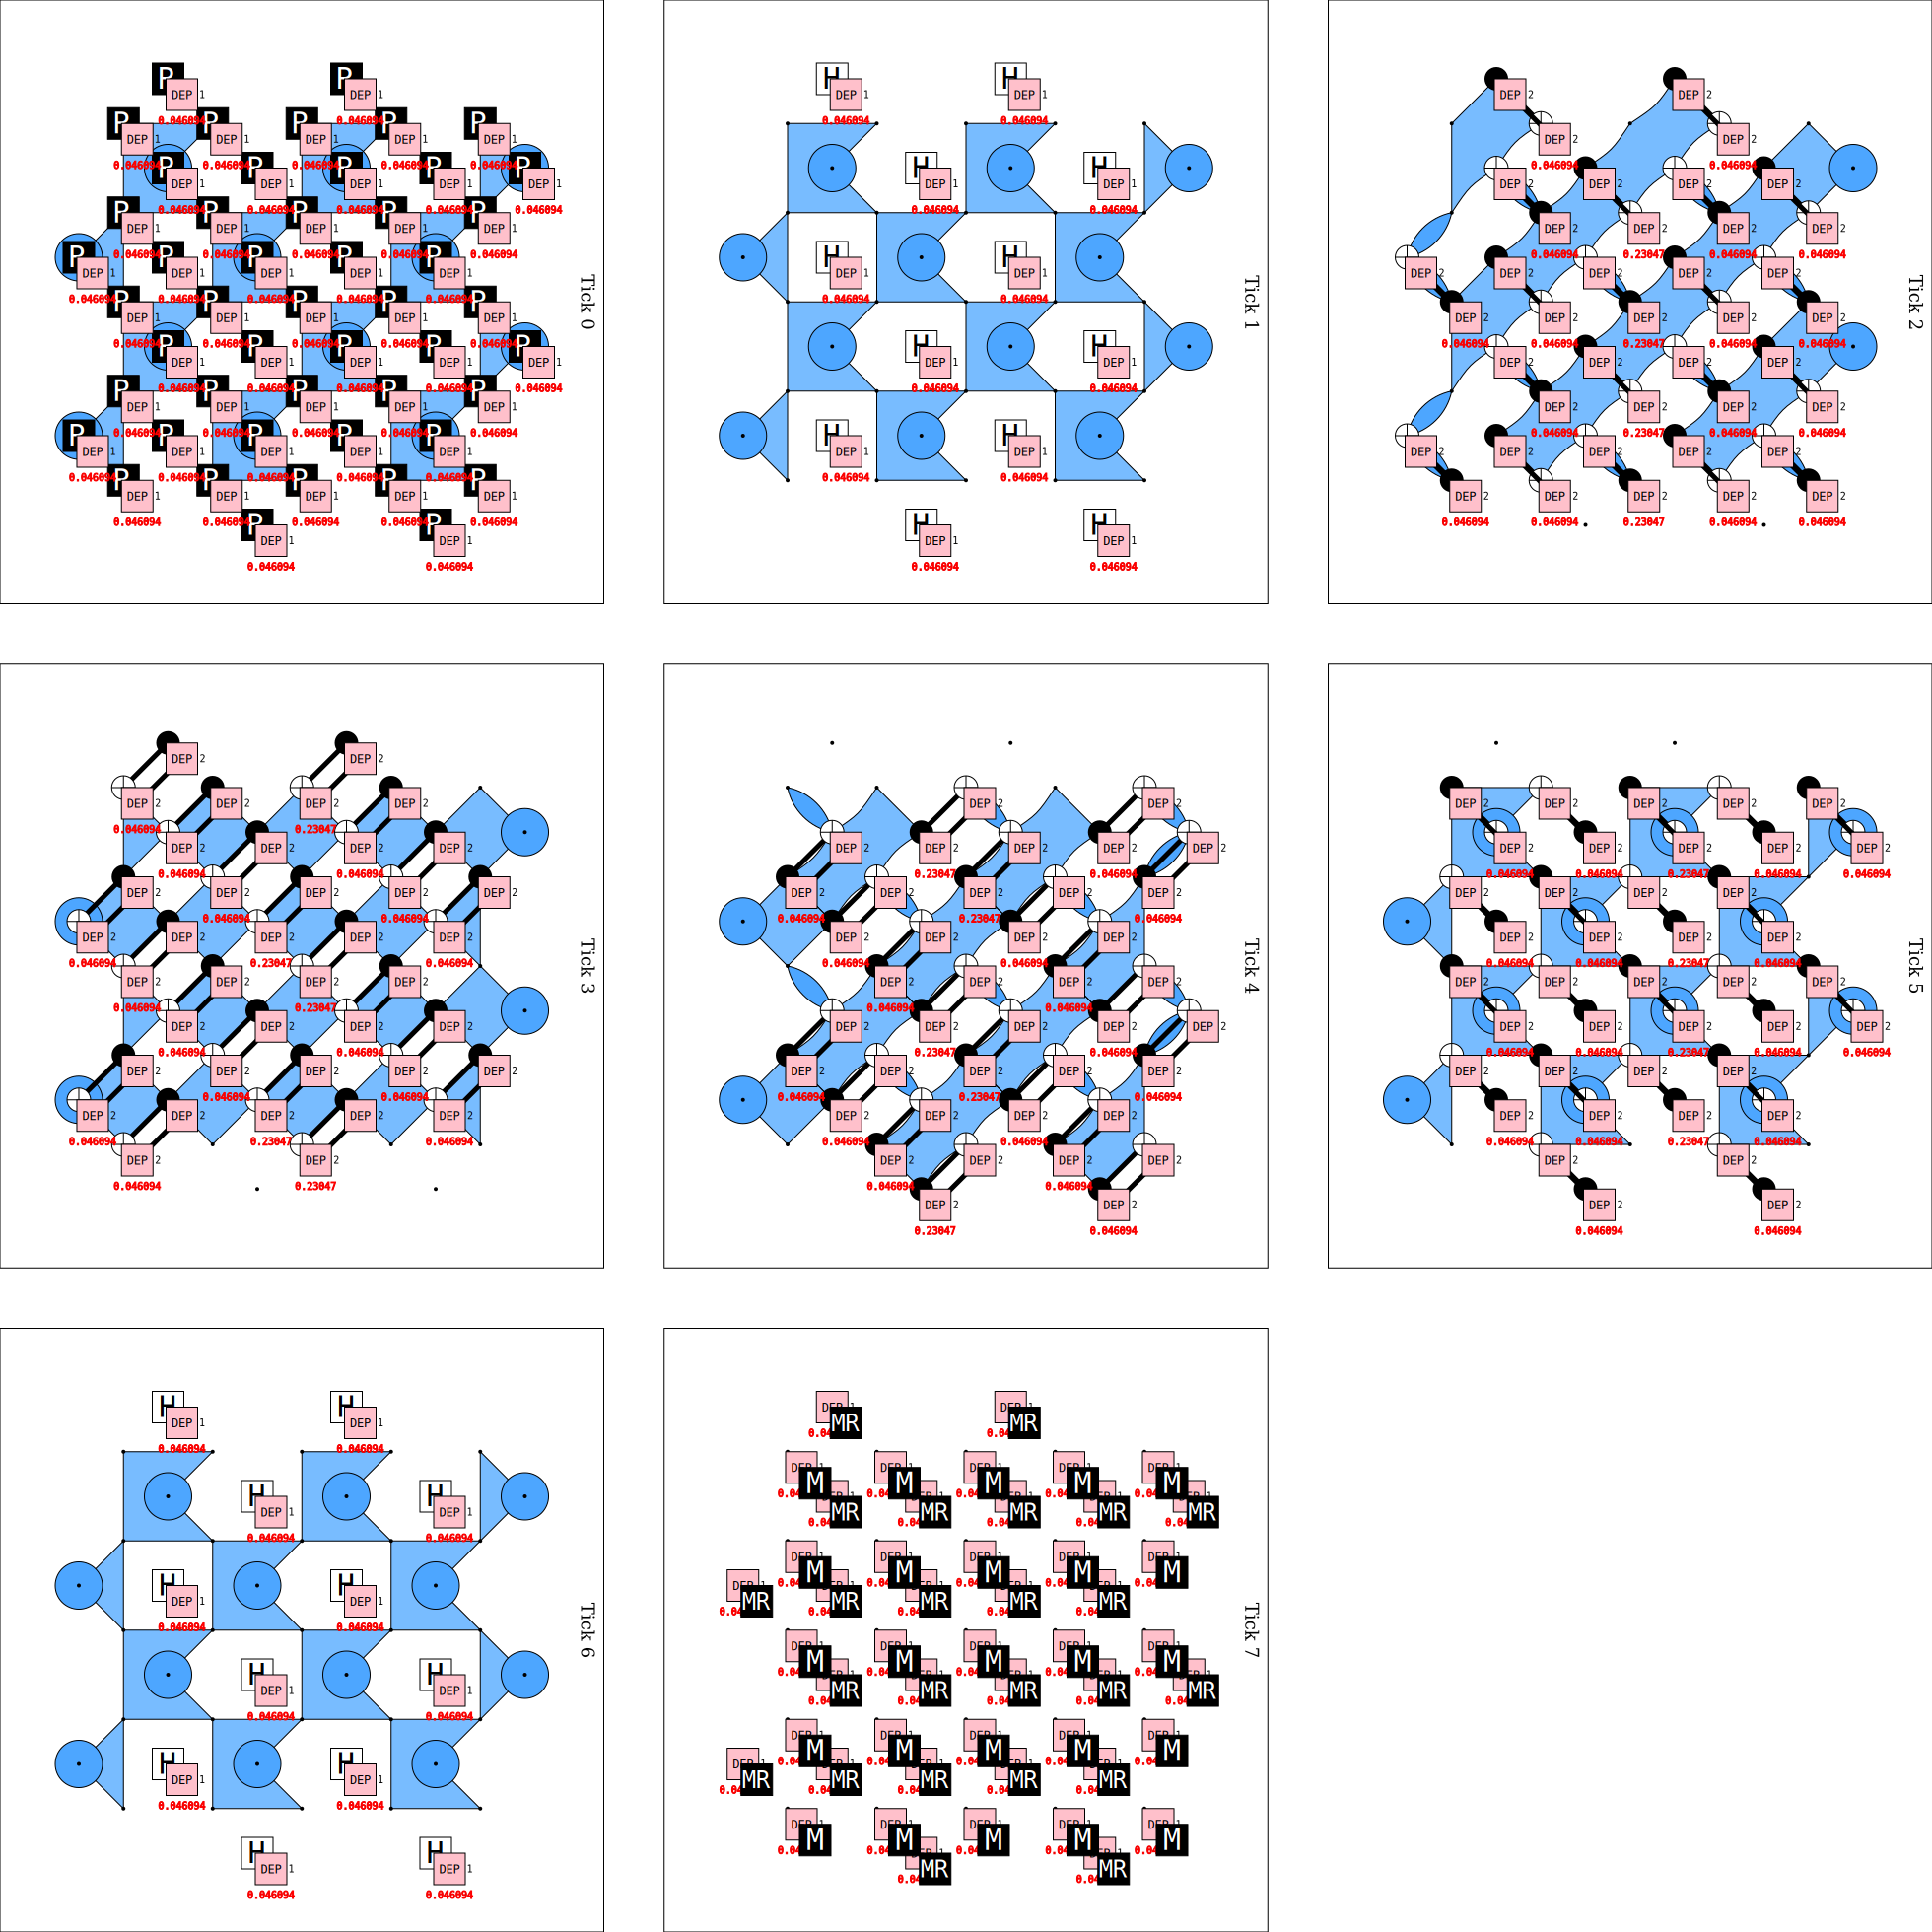

In [54]:
circuit.diagram("detslice-with-ops-svg")

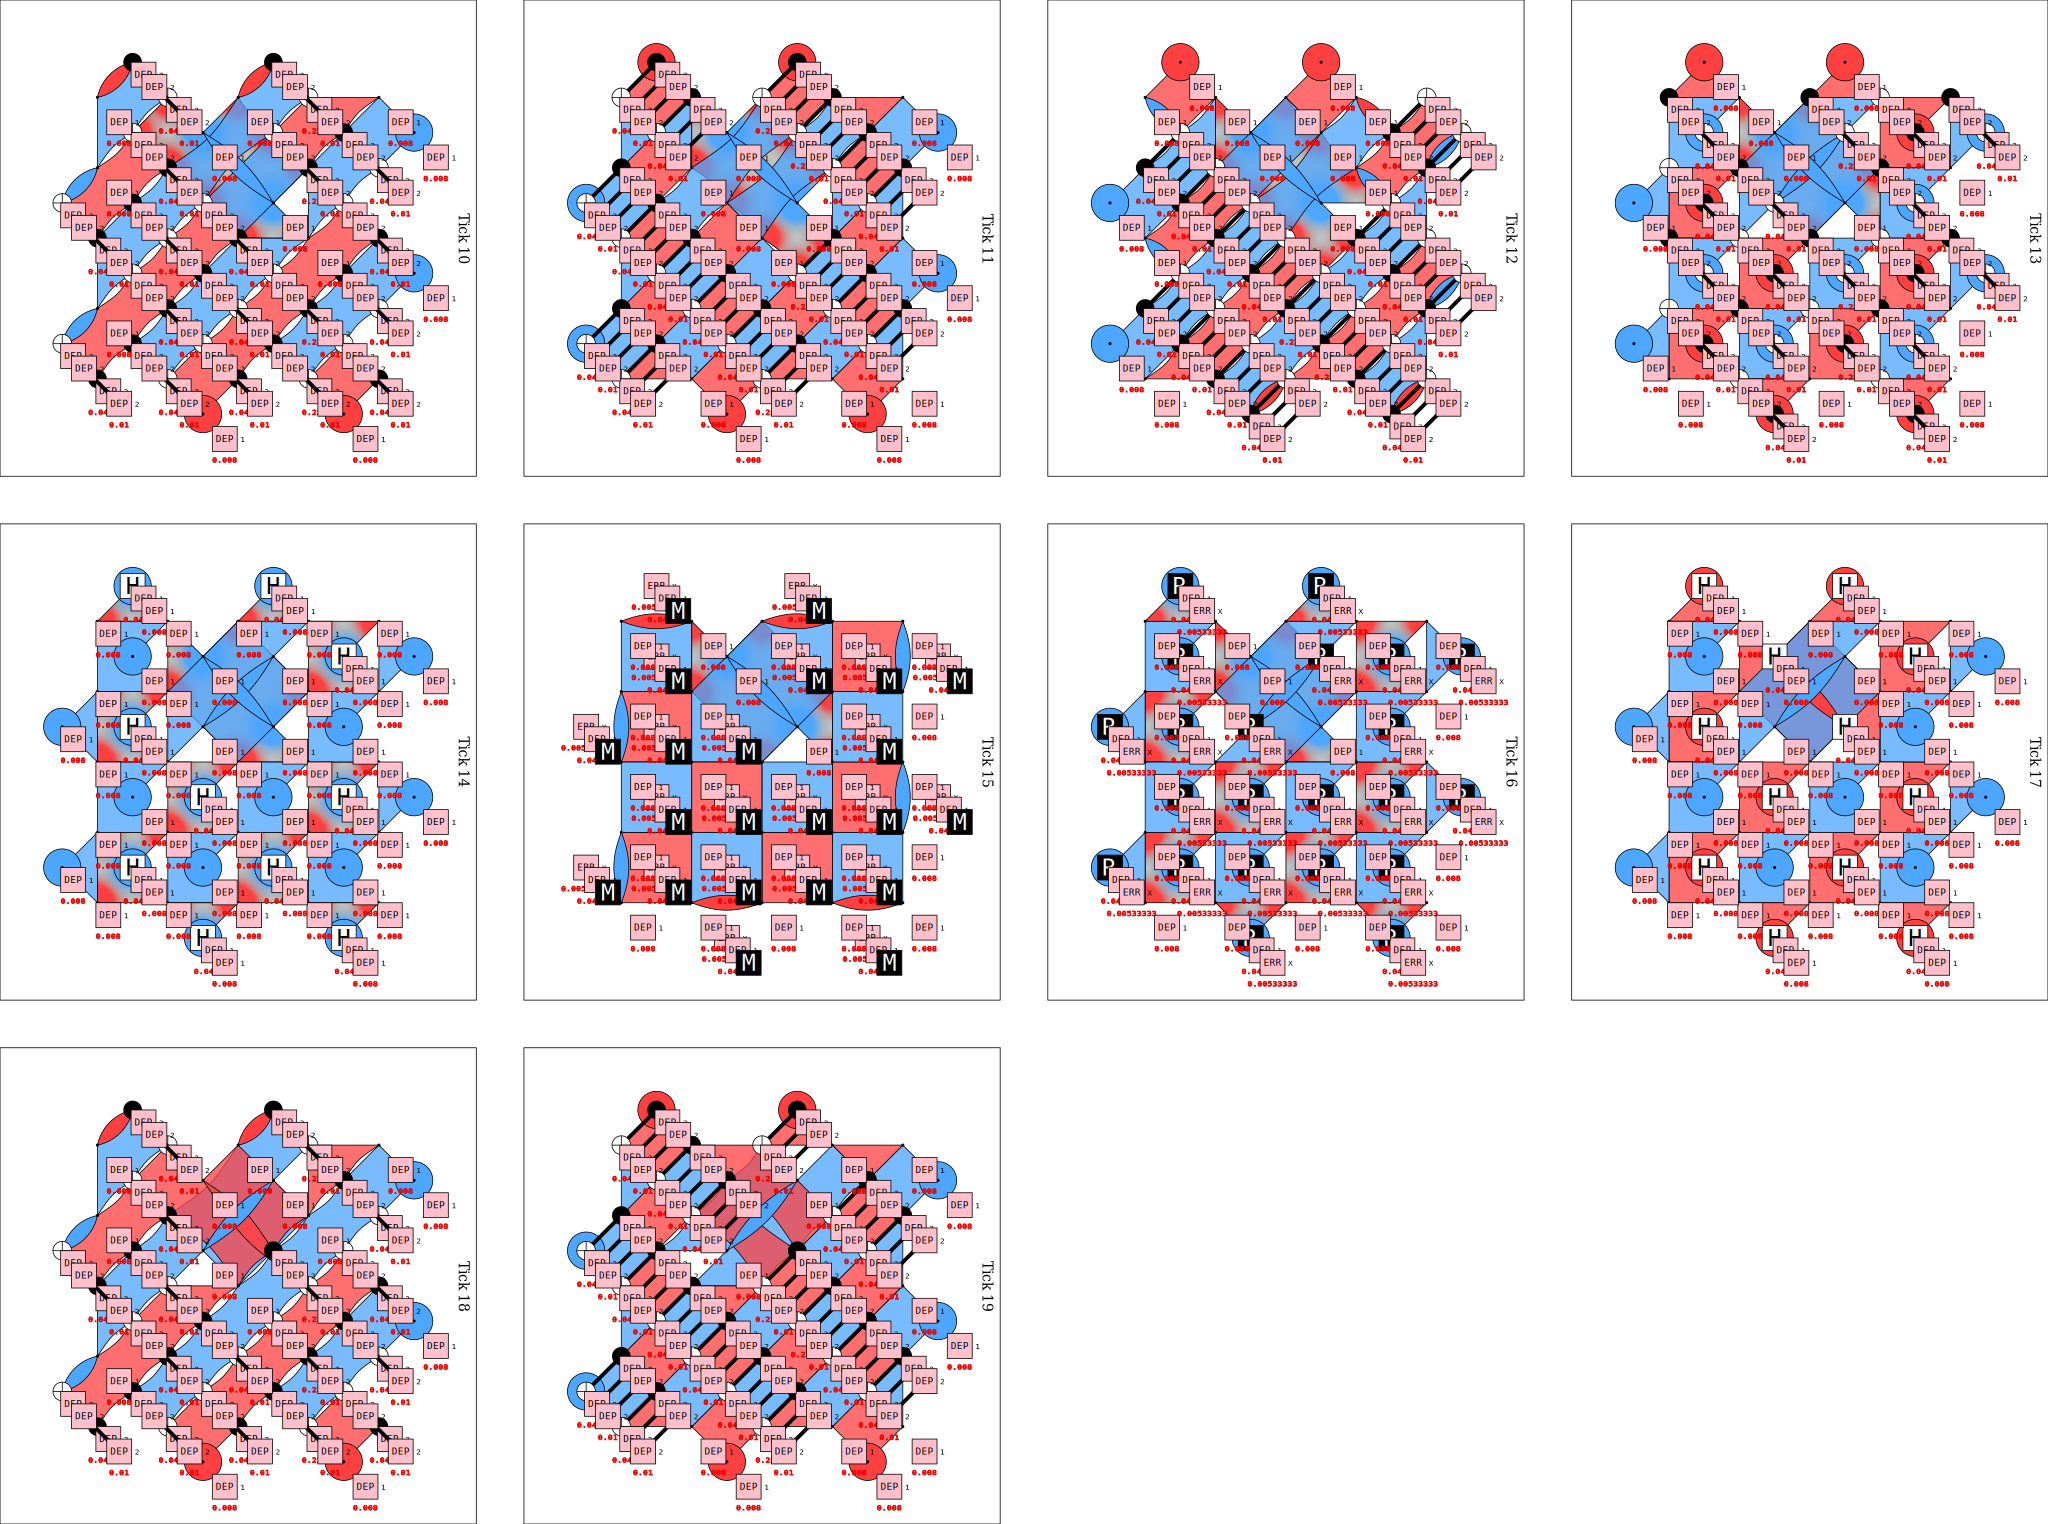

In [56]:
c = stim.Circuit.from_file("surface_d5_cut1.stim")
c = gen_entangled_circuit(c, d, r)
c.diagram('detslice-with-ops-svg', tick=range(10, 20))
    

In [57]:
c.to_file("surface_d5_cut1_with_errors.stim")